In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

import theano
import pymc3 as pm
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

from pymc3 import Normal,Metropolis, sample,find_MAP
plt.rcParams.update({'font.size': 18})
np.random.seed(0)
%matplotlib inline

In [12]:
def f(x):
    return 2*x + 1

x=np.random.uniform(0,1,10000)


x0 = []
y0 = []

x1 = []
y1 = []

Y1=np.zeros(len(x))

X1=np.zeros((len(x),2))


for i in range(len(x)):

    
    if np.random.random() < x[i]:
        x0.append(x[i])
        y0.append( f(x[i]) + np.random.normal(0,0.25)  )

        
    else:
        x1.append(x[i])
        y1.append( f(x[i]) + np.random.normal(0,0.25) ) 
'''    

plt.rcParams.update({'font.size': 18})
        
plt.figure(figsize=(10,8))
plt.scatter(x0,y0,marker='*',s=20,facecolors='none',edgecolors='r',alpha=0.3,label='class0')
plt.scatter(x1,y1,marker='o',s=20,facecolors='none',edgecolors='b',alpha=0.2,label='class1') # class 1
plt.axvline(0.1,color='blue')
plt.axvline(0.5,color='magenta')
plt.axvline(0.9,color='red')
plt.text(0.1,2.5,s='Pr(x=class0)=0.9 ' + '\n' + 'Pr(x=class1)=0.1 ' )
plt.text(0.5,3,s='Pr(x=class0)=0.5 ' + '\n' + 'Pr(x=class1)=0.5 ' )
plt.text(0.9,1,s='Pr(x=class0)=0.1 ' + '\n' + 'Pr(x=class1)=0.9 ' )
plt.legend()
plt.savefig('simulated.png')
plt.show()

'''


"    \n\nplt.rcParams.update({'font.size': 18})\n        \nplt.figure(figsize=(10,8))\nplt.scatter(x0,y0,marker='*',s=20,facecolors='none',edgecolors='r',alpha=0.3,label='class0')\nplt.scatter(x1,y1,marker='o',s=20,facecolors='none',edgecolors='b',alpha=0.2,label='class1') # class 1\nplt.axvline(0.1,color='blue')\nplt.axvline(0.5,color='magenta')\nplt.axvline(0.9,color='red')\nplt.text(0.1,2.5,s='Pr(x=class0)=0.9 ' + '\n' + 'Pr(x=class1)=0.1 ' )\nplt.text(0.5,3,s='Pr(x=class0)=0.5 ' + '\n' + 'Pr(x=class1)=0.5 ' )\nplt.text(0.9,1,s='Pr(x=class0)=0.1 ' + '\n' + 'Pr(x=class1)=0.9 ' )\nplt.legend()\nplt.savefig('simulated.png')\nplt.show()\n\n"

In [13]:
Y1=np.zeros(len(x0))
Y2=np.ones(len(x1))

Y=np.concatenate((Y1, Y2), axis=0)

x=np.concatenate((x0, x1), axis=0)
y=np.concatenate((y0, y1), axis=0)

X=np.stack((x, y), axis=-1)


X = np.asarray(X)
Y = np.asarray(Y)

#X = scale(X)
X = X.astype(float)
Y = Y.astype(float)

X.shape , Y.shape

((10000, 2), (10000,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.1)
scaler = StandardScaler()
scaler.fit(X_train)


X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
def reliability_curve(y_true, y_score, bins=10, normalize=False):


    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

In [16]:

def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network



# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.

ann_input = theano.shared(X_train)
ann_output = theano.shared(y_train)
neural_network = construct_nn(ann_input, ann_output)



In [17]:
with neural_network:
    start = find_MAP()
    step = Metropolis()
    trace = sample(50000, step, start=start)


Optimization terminated successfully.
         Current function value: 4564.208660
         Iterations: 353
         Function evaluations: 373
         Gradient evaluations: 373


100%|██████████| 50500/50500 [36:10<00:00, 23.26it/s]


In [18]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

Average Loss = 4,669.3: 100%|██████████| 50000/50000 [09:27<00:00, 88.10it/s]
Finished [100%]: Average Loss = 4,669.1


In [19]:
trace1 = approx.sample(draws=5000)

In [25]:

bins=10

reliability_scores1 = {}
y_score1 = {}

ann_input.set_value(X_test)
ann_output.set_value(y_test)

with neural_network:
    ppc1 = pm.sample_ppc(trace1, samples=100, progressbar=False)
    

pred1 = ppc1['out'].mean(axis=0) > 0.5

pred_VI=pred.astype(int)


y_score1['BNN_VI'] = ppc1['out'].mean(axis=0)
reliability_scores1['BNN_VI']=\
reliability_curve(y_test , y_score1['BNN_VI'], bins=bins , normalize=False)

In [26]:
bins=10

reliability_scores = {}
y_score = {}

ann_input.set_value(X_test)
ann_output.set_value(y_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=100, progressbar=False)
    

pred = ppc['out'].mean(axis=0) > 0.5

pred_MCMC=pred.astype(int)


y_score['BNN_MCMC'] = ppc['out'].mean(axis=0)
reliability_scores['BNN_MCMC']=\
reliability_curve(y_test , y_score['BNN_MCMC'], bins=bins , normalize=False)

Automatically created module for IPython interactive environment


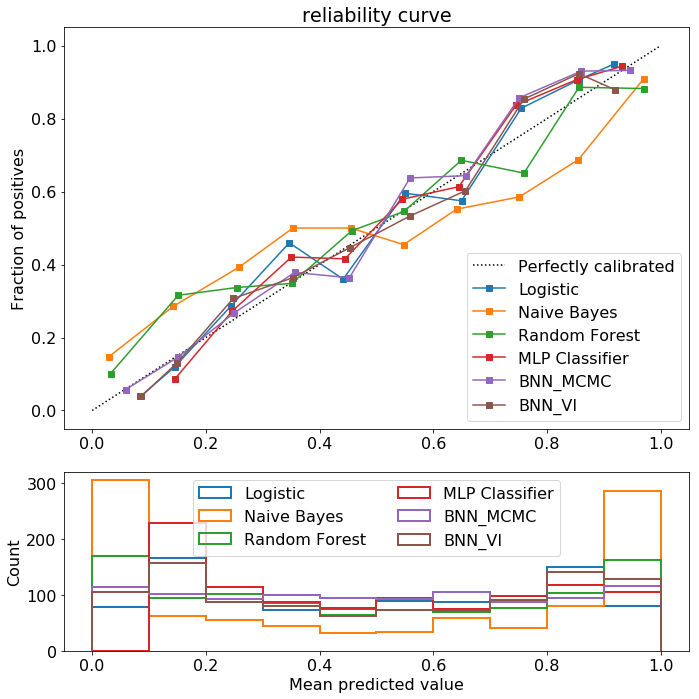

In [27]:
print(__doc__)

# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve


# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)
mlp = MLPClassifier(solver='sgd',alpha=1e-5,hidden_layer_sizes=(5,5),random_state=1)

# #############################################################################
# Plot calibration plots
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (rfc, 'Random Forest'),
                  (mlp,'MLP Classifier')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    ax1.plot(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan],"s-" ,label=method)
    
for method, y_score_ in y_score.items():
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    ax2.hist(y_score_, range=(0, 1), bins=bins, label=method,
             histtype="step", lw=2)
    
for method1, (y_score_bin_mean1, empirical_prob_pos1) in reliability_scores1.items():
    scores_not_nan1 = np.logical_not(np.isnan(empirical_prob_pos1))
    ax1.plot(y_score_bin_mean1[scores_not_nan1],
             empirical_prob_pos1[scores_not_nan1],"s-" ,label=method1)

    
for method1, y_score1_ in y_score1.items():
    y_score1_ = (y_score1_ - y_score1_.min()) / (y_score1_.max() - y_score1_.min())
    ax2.hist(y_score1_, range=(0, 1), bins=bins, label=method1,
             histtype="step", lw=2)
    
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('reliability curve')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.savefig('reliability_curves.png')
plt.show()

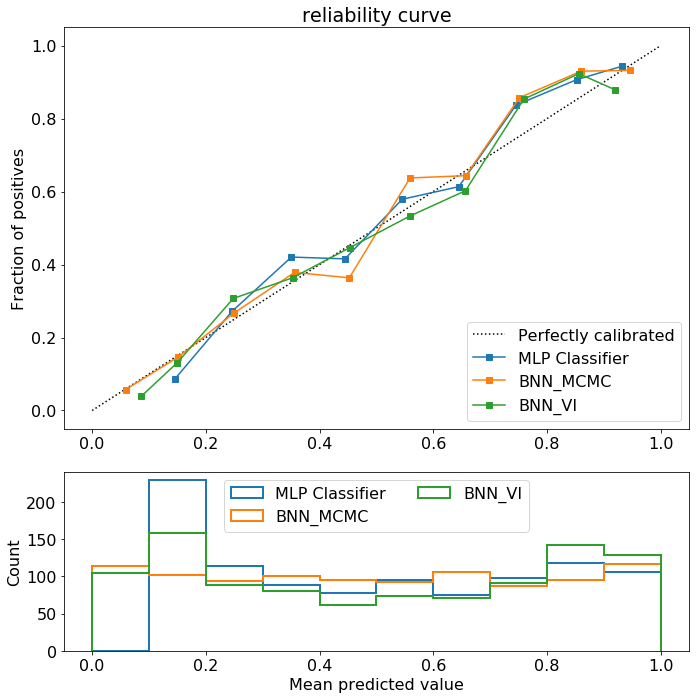

In [28]:
mlp = MLPClassifier(solver='sgd',alpha=1e-5,hidden_layer_sizes=(5,5),random_state=1)

# #############################################################################
# Plot calibration plots
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(mlp,'MLP Classifier')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    ax1.plot(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan],"s-" ,label=method)
    
for method, y_score_ in y_score.items():
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    ax2.hist(y_score_, range=(0, 1), bins=bins, label=method,
             histtype="step", lw=2)
    
for method1, (y_score_bin_mean1, empirical_prob_pos1) in reliability_scores1.items():
    scores_not_nan1 = np.logical_not(np.isnan(empirical_prob_pos1))
    ax1.plot(y_score_bin_mean1[scores_not_nan1],
             empirical_prob_pos1[scores_not_nan1],"s-" ,label=method1)

    
for method1, y_score1_ in y_score1.items():
    y_score1_ = (y_score1_ - y_score1_.min()) / (y_score1_.max() - y_score1_.min())
    ax2.hist(y_score1_, range=(0, 1), bins=bins, label=method1,
             histtype="step", lw=2)
    
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('reliability curve')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.savefig('reliability_curves_MCVINN.png')
plt.show()

In [96]:
Pred_prob_mlp=clf.predict_proba(X_test)

X_true=scaler.inverse_transform(X_test, copy=None)

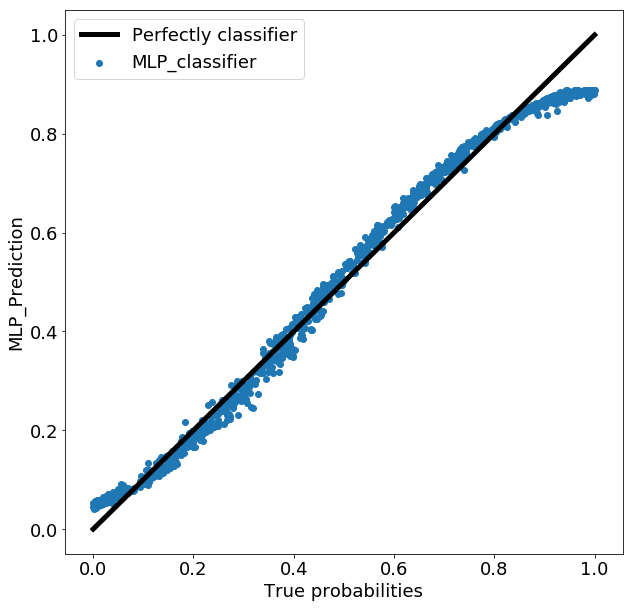

In [97]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 18})
plt.plot([0, 1], [0, 1], "k-", label="Perfectly classifier",linewidth=5)
plt.scatter(X_true[:,0][0:1000],Pred_prob_mlp[:,0][0:1000],label='MLP_classifier')
plt.ylabel('MLP_Prediction')
plt.xlabel('True probabilities')

plt.legend()
plt.savefig('true_mlp.png')
plt.show()

In [103]:
print('\tAccuracy = {}%'.format((y_test == pred_mlp).mean() ))
print("\tPrecision: %1.3f" % precision_score(y_test, pred_mlp))
print("\tRecall: %1.3f" % recall_score(y_test, pred_mlp))
print("\tF1: %1.3f\n" % f1_score(y_test, pred_mlp))

print('\tAccuracy = {}%'.format((y_test == pred_VI).mean() ))
print("\tPrecision: %1.3f" % precision_score(y_test, pred_VI))
print("\tRecall: %1.3f" % recall_score(y_test, pred_VI))
print("\tF1: %1.3f\n" % f1_score(y_test, pred_VI))

print('\tAccuracy = {}%'.format((y_test == pred_MCMC).mean() ))
print("\tPrecision: %1.3f" % precision_score(y_test, pred_MCMC))
print("\tRecall: %1.3f" % recall_score(y_test, pred_MCMC))
print("\tF1: %1.3f\n" % f1_score(y_test, pred_MCMC))

	Accuracy = 0.778%
	Precision: 0.793
	Recall: 0.765
	F1: 0.778

	Accuracy = 0.771%
	Precision: 0.786
	Recall: 0.757
	F1: 0.771

	Accuracy = 0.782%
	Precision: 0.798
	Recall: 0.767
	F1: 0.782



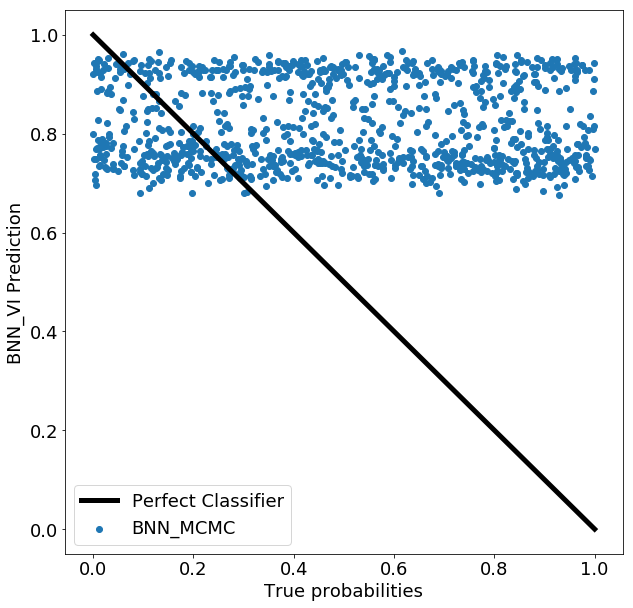

In [99]:
pred_prob_MCMC=ppc['out'].mean(axis=0)
pred_std=ppc['out'].std(axis=0)

plt.figure(figsize=(10,10))
plt.plot([1, 0], [0, 1], "k-", label="Perfect Classifier",linewidth=5)
plt.scatter(X_true[:,0][0:1000],pred_prob_MCMC[0:1000],label='BNN_MCMC')
plt.ylabel('BNN_VI Prediction')
plt.xlabel('True probabilities')
plt.gca().invert_xaxis()
plt.savefig('tru_MCMC.png')
plt.legend()
plt.show()

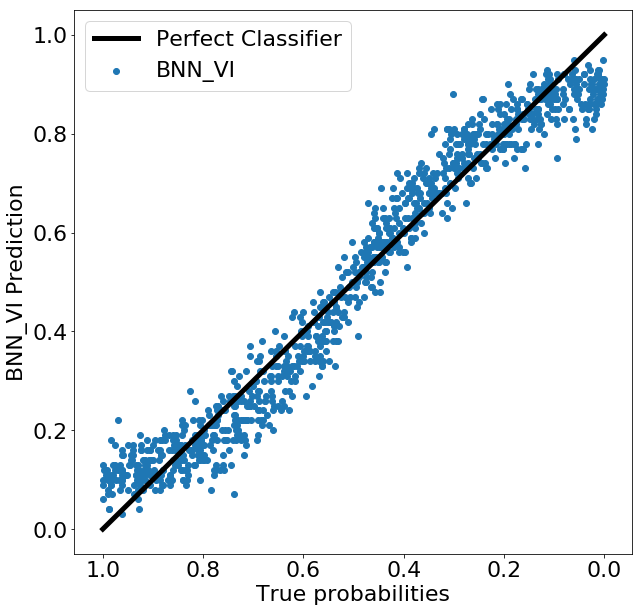

In [94]:
pred_prob_VI=ppc1['out'].mean(axis=0)
pred_std1=ppc1['out'].std(axis=0)

plt.figure(figsize=(10,10))
plt.plot([1, 0], [0, 1], "k-", label="Perfect Classifier",linewidth=5)
plt.scatter(X_true[:,0][0:1000],pred_prob_VI[0:1000],label='BNN_VI')
plt.ylabel('BNN_VI Prediction')
plt.xlabel('True probabilities')
plt.gca().invert_xaxis()

plt.legend()
plt.savefig('tru_VI.png')
plt.show()

In [68]:
clf = MLPClassifier(solver='sgd',alpha=1e-5,hidden_layer_sizes=(5,5),random_state=1)
clf.fit(X_train, y_train)
pred_mlp = clf.predict(X_test)

In [73]:
from sklearn.metrics import confusion_matrix
import itertools

class_names = np.array(['class0','class1'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
  
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

 
    plt.tight_layout()

Normalized confusion matrix
[[0.792 0.208]
 [0.235 0.765]]


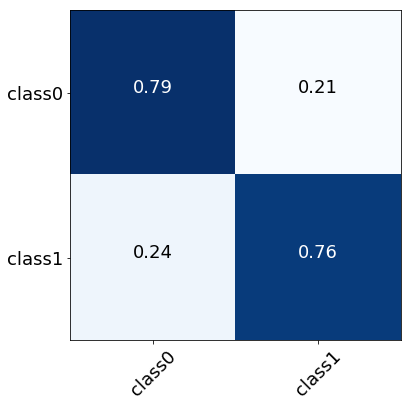

In [74]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_mlp)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.savefig('confusion_mlp.png')
plt.show()

Normalized confusion matrix
[[0.798 0.202]
 [0.233 0.767]]


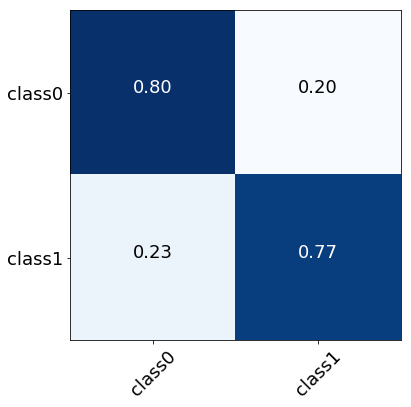

In [79]:
plt.figure(figsize=(8,6))
cnf_matrix = confusion_matrix(y_test, pred_MCMC)
np.set_printoptions(precision=3)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.savefig('confusion_MCMC.png')
plt.show()

Normalized confusion matrix
[[0.786 0.214]
 [0.243 0.757]]


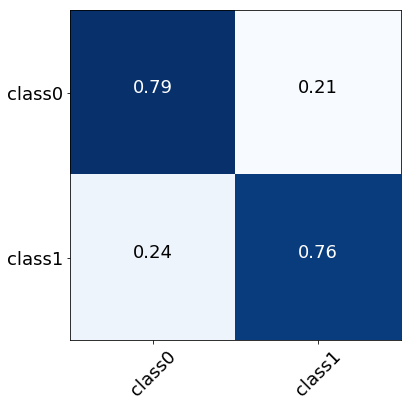

In [80]:
cnf_matrix = confusion_matrix(y_test, pred_VI)
np.set_printoptions(precision=3)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.savefig('confusion_VI.png')
plt.show()

/home/tumisang/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5224ce9b0>,
      dtype=object)

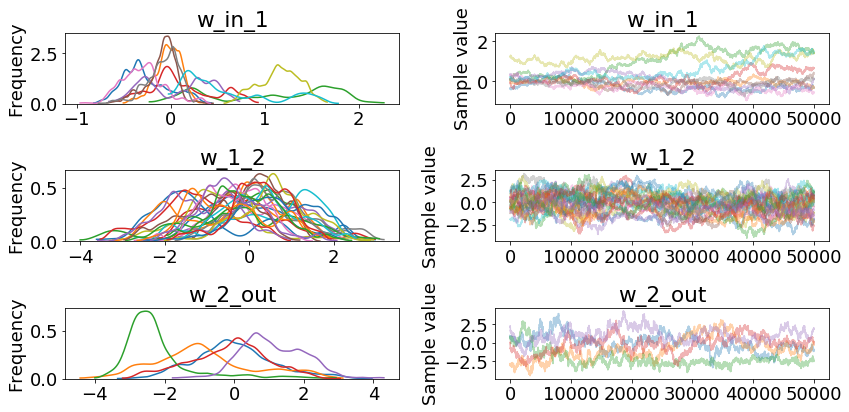

In [62]:
pm.traceplot(trace)

/home/tumisang/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc522354fd0>,
      dtype=object)

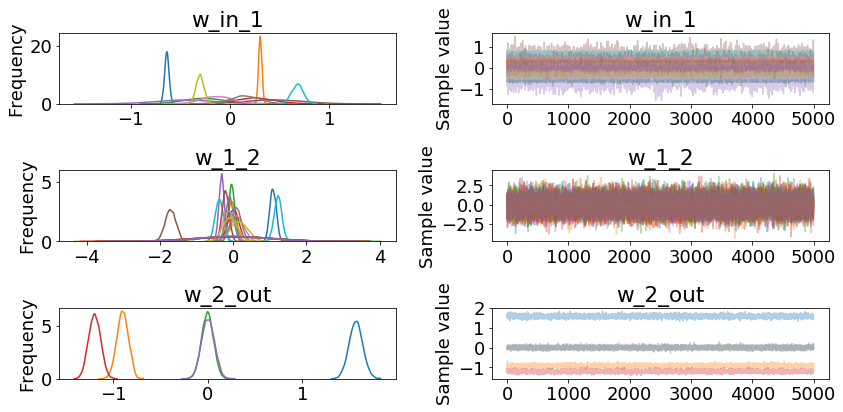

In [64]:
pm.traceplot(trace1)

In [88]:
import seaborn as sns

grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)
with neural_network:
    ppc = pm.sample_ppc(trace1, samples=500, progressbar=False)



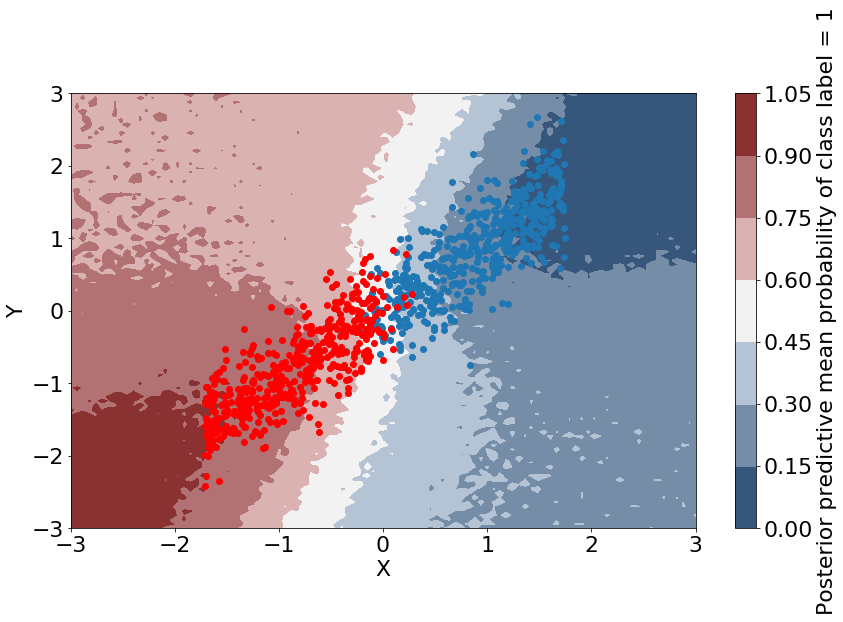

In [89]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 1');
plt.savefig('predictive_prob_MCMC.png')

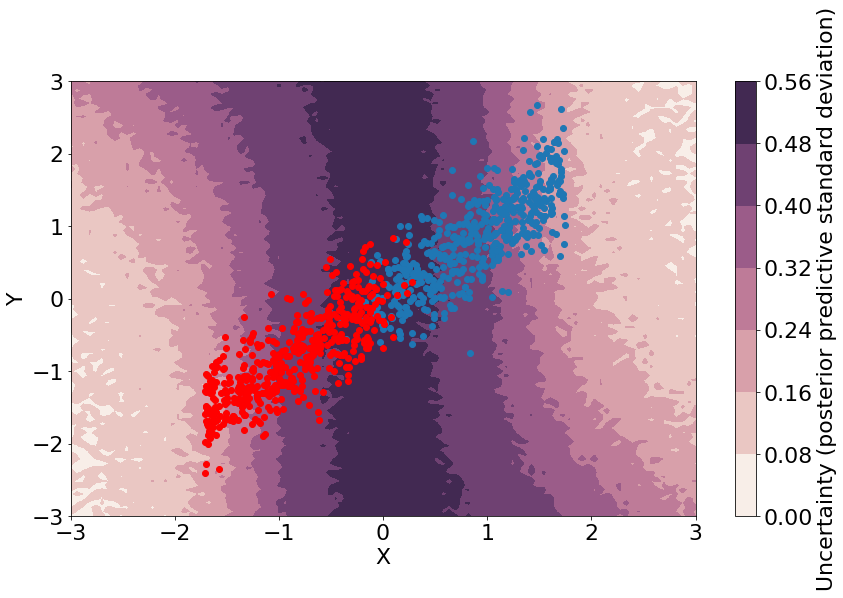

In [87]:
plt.rcParams.update({'font.size': 22})

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)')
plt.savefig('uncertainty_post_MCMC.png')

